In [2]:
!pip install wordcloud

     -------------------------------------- 220.7/220.7 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp39-cp39-win_amd64.whl size=161117 sha256=bfbf2e16b012a339a3d3bc5fa8c63381a164c11fd2365df822756db364507f2e
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\f9\7a\dd\06ef8b5dfe5483f6204133c08eeb16c287cc2c05e290ae2fc0
Successfully built wordcloud


In [3]:
# load libraries
import numpy as np # linear algebra
import pandas as pd # data processing

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [5]:
train_df = pd.read_csv("./Corona_NLP_train.csv", encoding='latin-1')
test_df=pd.read_csv("./Corona_NLP_test.csv")

In [6]:
# function to plot confusion matrix
def vis_conf_matrix(conf_martix, model_name):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_martix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_martix.flatten()/np.sum(conf_martix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _, ax = plt.subplots(figsize = (6,6))
    ax = sns.heatmap(conf_martix, annot=labels, fmt = '', 
                     annot_kws = {"size": 20, "weight": "bold"}, cmap = 'Blues')  
    labels = ['False', 'True']
    ax.set_title('Confusion Matrix for {}'.format(model_name), fontsize = 15)
    ax.set_xticklabels(labels, fontsize = 10)
    ax.set_yticklabels(labels, fontsize = 10)
    ax.set_xlabel('Prediction', fontsize = 15)
    ax.set_ylabel('Ground Truth', fontsize = 15)

In [7]:
# Label is the target columns
train_df['label'] = train_df['Sentiment'].factorize()[0]
train_df['label'].nunique()

5

In [8]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,2


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Positive'),
  Text(1, 0, 'Negative'),
  Text(2, 0, 'Neutral'),
  Text(3, 0, 'Extremely Positive'),
  Text(4, 0, 'Extremely Negative')])

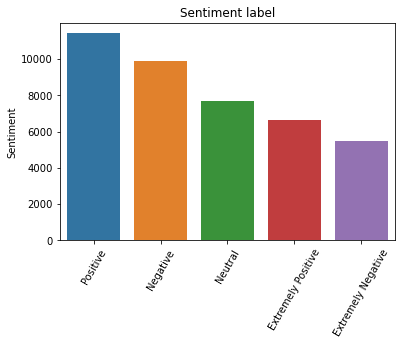

In [9]:
sns.barplot(x = train_df['Sentiment'].value_counts().index, 
            y = train_df['Sentiment'].value_counts()).set_title('Sentiment label')
plt.xticks(rotation = 60)

In [10]:
train_df.label.replace(to_replace = {'Extremely Positive' : 1, 'Positive' : 1, 'Neutral' : 1, 
                                   'Negative' : 0, 'Extremely Negative' : 0}, inplace=True)
train_df.label.unique()

array([0, 1, 2, 3, 4], dtype=int64)

Text(0.5, 1.0, 'Sentiment label')

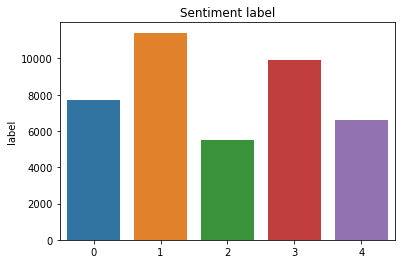

In [11]:
sns.barplot(x = train_df['label'].value_counts().index, 
            y = train_df['label'].value_counts()).set_title('Sentiment label')

In [12]:
# Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Lower casing
def lower(text):
    low_text = text.lower()
    return low_text

# Number removal
def remove_num(text):
    remove = re.sub(r'\d+', '' ,text)
    return remove
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str


train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_urls(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_html(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: lower(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_num(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: punctuation_removal(x))
#data.drop(columns = ['OriginalTweet'], inplace = True)

array([[<AxesSubplot:title={'center':'len_char'}>]], dtype=object)

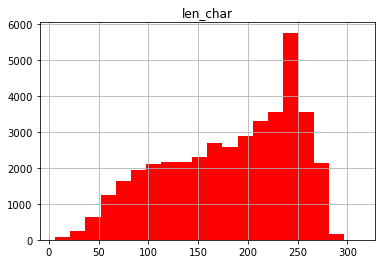

In [14]:
train_df['len_char'] = train_df.OriginalTweet.apply(lambda x: len(x))
train_df.hist(column = 'len_char', bins = 20,color='red')

In [15]:
def create_corpus(train_df, target_label, label_col = 'label', text_col = 'OriginalTweet'):
    corpus = []
    
    for x in train_df[train_df[label_col] == target_label][text_col].str.split():
        for i in x:
            corpus.append(i)
    return corpus


In [16]:
corpus_pos = create_corpus(train_df, 1)
corpus_neg = create_corpus(train_df, 0)

print("Positives: ", len(corpus_pos))
print("Negatives: ", len(corpus_neg))

Positives:  338521
Negatives:  167395


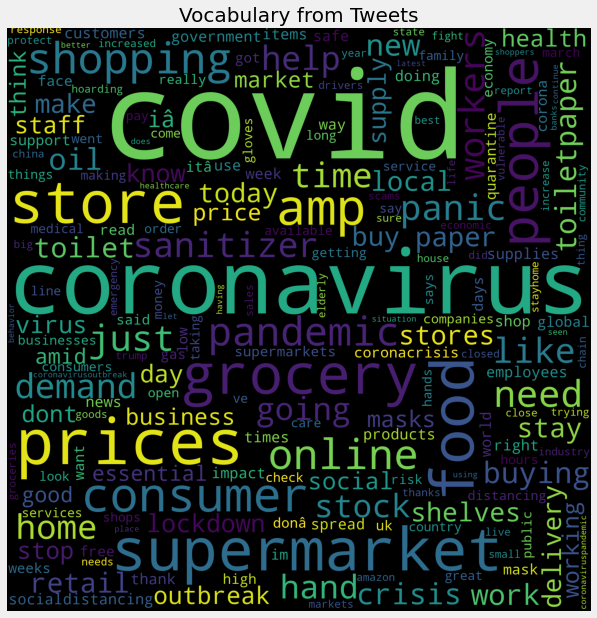

In [17]:
# lets plot the Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df['OriginalTweet'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Tweets", fontsize = 20)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

# Keeping only the neccessary columns
data = train_df[['OriginalTweet','label']]

In [19]:
max_fatures = 2000

tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['OriginalTweet'].values)
X = tokenizer.texts_to_sequences(data['OriginalTweet'].values)
X = pad_sequences(X, 28) 

Y = pd.get_dummies(data['label']).values

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)

print("The shape of train:",X_train.shape)
print("The shape of train:",X_test.shape)
print("The shape of train:",Y_train.shape)
print("The shape of train:",Y_test.shape)

The shape of train: (32925, 28)
The shape of train: (8232, 28)
The shape of train: (32925, 5)
The shape of train: (8232, 5)


In [21]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128,recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))

history=model.compile(loss = 'BinaryCrossentropy', optimizer='adam',metrics = ['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 28, 196)           254800    
                                                                 
 lstm_1 (LSTM)               (None, 128)               166400    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 677,845
Trainable params: 677,845
Non-trainable params: 0
__________________________________________________

In [27]:
batch_size = 512

model.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/100
65/65 [==============================] - 91s 1s/step - loss: 0.4996 - accuracy: 0.2910 - val_loss: 0.4675 - val_accuracy: 0.3310
Epoch 2/100
65/65 [==============================] - 77s 1s/step - loss: 0.4499 - accuracy: 0.3670 - val_loss: 0.4312 - val_accuracy: 0.4178
Epoch 3/100
65/65 [==============================] - 94s 1s/step - loss: 0.3918 - accuracy: 0.5085 - val_loss: 0.3622 - val_accuracy: 0.5697
Epoch 4/100
65/65 [==============================] - 84s 1s/step - loss: 0.3443 - accuracy: 0.5966 - val_loss: 0.3492 - val_accuracy: 0.5924
Epoch 5/100
65/65 [==============================] - 78s 1s/step - loss: 0.3300 - accuracy: 0.6265 - val_loss: 0.3347 - val_accuracy: 0.6250
Epoch 6/100
65/65 [==============================] - 78s 1s/step - loss: 0.3213 - accuracy: 0.6408 - val_loss: 0.3329 - val_accuracy: 0.6256
Epoch 7/100
65/65 [==============================] - 82s 1s/step - loss: 0.3187 - accuracy: 0.6453 - val_loss: 0.3337 - val_accuracy: 0.6207
Epoch 8/100
6

Epoch 59/100
65/65 [==============================] - 80s 1s/step - loss: 0.1736 - accuracy: 0.8217 - val_loss: 0.4584 - val_accuracy: 0.6035
Epoch 60/100
65/65 [==============================] - 79s 1s/step - loss: 0.1727 - accuracy: 0.8245 - val_loss: 0.4612 - val_accuracy: 0.5975
Epoch 61/100
65/65 [==============================] - 80s 1s/step - loss: 0.1675 - accuracy: 0.8296 - val_loss: 0.4756 - val_accuracy: 0.5989
Epoch 62/100
65/65 [==============================] - 80s 1s/step - loss: 0.1646 - accuracy: 0.8333 - val_loss: 0.4740 - val_accuracy: 0.6037
Epoch 63/100
65/65 [==============================] - 80s 1s/step - loss: 0.1639 - accuracy: 0.8318 - val_loss: 0.4821 - val_accuracy: 0.6003
Epoch 64/100
65/65 [==============================] - 79s 1s/step - loss: 0.1630 - accuracy: 0.8350 - val_loss: 0.4810 - val_accuracy: 0.5975
Epoch 65/100
65/65 [==============================] - 80s 1s/step - loss: 0.1586 - accuracy: 0.8390 - val_loss: 0.4965 - val_accuracy: 0.5983
Epoch 

In [28]:
m1=model.save('h1')
print(m1)

loss,accuracy=model.evaluate(X_train,Y_train)

INFO:tensorflow:Assets written to: h1\assets


None
1029/1029 [==============================] - 25s 24ms/step - loss: 0.0402 - accuracy: 0.9725


In [29]:
print(loss)
print(accuracy)

0.040213849395513535
0.9724829196929932
